# CSE6250BDH FINAL PROJECT
## Predicting Heart Failure Readmission from Clinical Notes Using Deep Learning (CNN)


In [2]:
import torch
import pandas as pd
import numpy as np
import math
import datetime
import builtins
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from gensim.models import KeyedVectors
import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer 
from nltk.corpus import stopwords
from string import punctuation
import time
import os
import psutil
import importlib
import utility  # Import your module if it's not already imported

from utility import *
from ReadmissionCNN import *
from torch.utils.data import TensorDataset, Dataset
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, f1_score



nltk.download('stopwords')
nltk.download('punkt')

n_cores = psutil.cpu_count(logical=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssiddiqui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssiddiqui\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
print(f"number of cores: {n_cores}")
print(torch.__version__)

number of cores: 8
2.0.0+cu118


In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


True
1
0
Quadro RTX 4000
Using device: cuda


In [5]:
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Quadro RTX 4000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
def custom_print(*args, **kwargs):
    now = datetime.now()
    dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
    builtins.print(f"[{dt_string}] -", *args, **kwargs)

# Override the built-in print function
print = custom_print    

# Restore the original print function
print = builtins.print


# LOAD PUBMED & PMC WORD2VEC MODEL INTO MEMORY

In [7]:
# Load the Word2Ven model (substitute with the path to your downloaded vectors)
# The model can be downloaded from: https://bio.nlplab.org/#word-vector-tools
# Word vectors > http://evexdb.org/pmresources/vec-space-models/
#PubMed abstract and PMC full text vector model  = './vector_embeddings/PubMed-and-PMC-w2v.bin'

## This is large file, I did not check into Github repository, please download it from the above location and place it in vector_embeddings folder

start_time = time.time()
pubmed_pmc_wordvector_path = './vector_embeddings/PubMed-and-PMC-w2v.bin'
pubmed_pmc_wordvector = KeyedVectors.load_word2vec_format(pubmed_pmc_wordvector_path, binary=True)
end_time = time.time()
pubmed_pmc_wordvector_model_load_elapsed_time = round(end_time - start_time,4)
print(f'PubMed & PMC vector model was successfully loaded in {utility.parse_time(pubmed_pmc_wordvector_model_load_elapsed_time)}')
print(f'Pubmed & PMC Word2Vec model Embedding Dimension: {pubmed_pmc_wordvector.vector_size}')

PubMed & PMC vector model was successfully loaded in 21.0 sec
Pubmed & PMC Word2Vec model Embedding Dimension: 200


# DATA PRE-PROCESSING

In [8]:
stop_words = set(stopwords.words('english'))
pattern = r'\b[a-zA-Z]+\b' # regex pattern for matching words only
regex_tokenizer = RegexpTokenizer(pattern)
#regex_tokenizer = RegexpTokenizer(r'\w+') # \w+ tokenizes the input text into words, extracting sequences of alphanumeric characters as tokens and ignoring punctuations and whitespace.




In [9]:
hf_admission_notes_with_labels = pd.read_csv('.\data\mimic_hf_admission_notes_with_readmission_labels.csv')

hf_admission_notes_with_labels["ORIGINAL_INDEX"] = hf_admission_notes_with_labels.index

hf_admission_notes_with_labels.shape

(13746, 8)

In [10]:
hf_admission_notes_with_labels.head()

,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,ORIGINAL_INDEX
0,138376,124,Unit No: [**Numeric Identifier 13036**]\nAdmi...,Report,2165-12-31 18:55:00,0,0,0
1,138523,89292,Admission Date: [**2169-12-23**] ...,Report,2169-12-23 20:05:00,0,0,1
2,152398,1351,Admission Date: [**2188-5-3**] D...,Report,2188-05-03 12:39:00,0,0,2
3,107779,15048,Admission Date: [**2195-9-24**] Discharge...,Report,2195-09-24 16:38:00,0,0,3
4,129665,55611,Admission Date: [**2172-4-13**] ...,Report,2172-04-13 19:06:00,0,0,4


In [11]:
#len(hf_admission_notes_with_labels.iloc[0,2].split(" "))


In [12]:
hf_admission_notes_with_labels[["READMISSION","READMISSION_30DAYS"]].agg(["sum","count"])

,READMISSION,READMISSION_30DAYS
sum,3543,962
count,13746,13746


### TOKENIZE AND PROCESS CLINICAL NOTES

In [13]:
hf_admission_notes_with_labels['TEXT_LEN'] = hf_admission_notes_with_labels['TEXT'].apply(lambda words: len(words.split(" ")))
hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT'] = hf_admission_notes_with_labels['TEXT'].apply(lambda words: utility.preprocess_sentence(regex_tokenizer,punctuation,stop_words, words))
hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'] = hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT'].apply(lambda words: len(words.split(" ")))

hf_admission_notes_with_labels.head()
#hf_admission_notes_with_labels.sort_values("TEXT_LEN",ascending=False).head()

,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,ORIGINAL_INDEX,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,138376,124,Unit No: [**Numeric Identifier 13036**]\nAdmi...,Report,2165-12-31 18:55:00,0,0,0,839,unit numeric identifier admission date dischar...,520
1,138523,89292,Admission Date: [**2169-12-23**] ...,Report,2169-12-23 20:05:00,0,0,1,3668,admission date discharge date date birth sex s...,2602
2,152398,1351,Admission Date: [**2188-5-3**] D...,Report,2188-05-03 12:39:00,0,0,2,1658,admission date discharge date date birth sex s...,1171
3,107779,15048,Admission Date: [**2195-9-24**] Discharge...,Report,2195-09-24 16:38:00,0,0,3,669,admission date discharge date service company ...,440
4,129665,55611,Admission Date: [**2172-4-13**] ...,Report,2172-04-13 19:06:00,0,0,4,2431,admission date discharge date date birth sex s...,1732


In [14]:
hf_admission_notes_with_labels.iloc[0,9]

'unit numeric identifier admission date discharge date date birth sex service admission diagnosis pneumonia colonic pseudo obstruction last name un syndrome cerebrovascular disease history cerebrovascular accident status post bilateral carotid endarterectomies coronary artery disease status post five vessel coronary artery bypass grafting status post coronary catheterization hypertension prostate cancer hepatitis c hyperlipidemia chronic obstructive pulmonary disease emphysema history adenocarcinoma lung status post right upper lobectomy chronic renal insufficiency history cavitating pneumonias discharge diagnoses sepsis multisystem organ failure respiratory failure pneumonia colonic perforation status post extended right colectomy end ileostomy status post tracheostomy status post abdominal wound dehiscence status post fascial closure acute chronic renal failure malnutrition admission history physical known firstname known lastname year old gentleman multiple comorbidities admitted re

Avg Tokenized & Processed Notes Length: 1162.8635239342354
Max Tokenized & Processed Notes Length: 4656
Min Tokenized & Processed Notes Length: 28
Std Tokenized & Processed Notes Length: 506.33322456783924
3092


,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,ORIGINAL_INDEX,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,138376,124,Unit No: [**Numeric Identifier 13036**]\nAdmi...,Report,2165-12-31 18:55:00,0,0,0,839,unit numeric identifier admission date dischar...,520
1,138523,89292,Admission Date: [**2169-12-23**] ...,Report,2169-12-23 20:05:00,0,0,1,3668,admission date discharge date date birth sex s...,2602
2,152398,1351,Admission Date: [**2188-5-3**] D...,Report,2188-05-03 12:39:00,0,0,2,1658,admission date discharge date date birth sex s...,1171
3,107779,15048,Admission Date: [**2195-9-24**] Discharge...,Report,2195-09-24 16:38:00,0,0,3,669,admission date discharge date service company ...,440
4,129665,55611,Admission Date: [**2172-4-13**] ...,Report,2172-04-13 19:06:00,0,0,4,2431,admission date discharge date date birth sex s...,1732


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


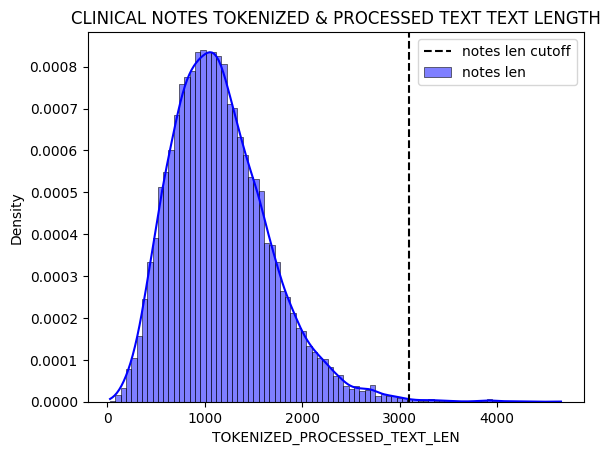

In [15]:
hf_admission_notes_with_labels["TOKENIZED_PROCESSED_TEXT_LEN"].max()

#rule of thumb from statistics that approximately 99.7% of data points in a normally distributed dataset lie within three standard deviations of the mean
notes_len_cutoff = np.round(hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].mean() + 3*hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].std()).astype(int) 


#Instead of using the mean and standard deviation, consider using the median and interquartile range (IQR) to set max_seq_len,
# since the median and IQR are more robust to skewed data and outliers.

q75, q25 = np.percentile(hf_admission_notes_with_labels['TEXT_LEN'], [75 ,25])
iqr = q75 - q25
notes_len_cutoff = np.round(q75 + (1.1 * iqr)).astype(int) # Adjust 1.5 based on how inclusive you want to be of the outlier data.


print(f"Avg Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].mean()}")
print(f"Max Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].max()}")
print(f"Min Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].min()}")
print(f"Std Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].std()}")
print(notes_len_cutoff)
display(hf_admission_notes_with_labels.head(5))

#https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
sns.histplot(hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'], kde=True, stat="density", color='b', label='notes len')
plt.axvline(x=notes_len_cutoff, color='k', linestyle='--', label='notes len cutoff')
plt.title('CLINICAL NOTES TOKENIZED & PROCESSED TEXT TEXT LENGTH'); plt.legend()
plt.show()


## DOWNSAMPLE THE MAJORITY CLASS TO MATCH READMISSION SAMPLES 

### BALANCED SAMPLE DATASET

In [16]:

# Separate majority and minority classes
hf_readmission_notes_majority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION == 0]
hf_readmission_notes_minority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION == 1]
# Downsample majority class
#hf_readmission_notes_majority_downsampled = hf_readmission_notes_majority.sample(n=len(hf_readmission_notes_minority), random_state=42)
hf_readmission_notes_majority_downsampled = hf_readmission_notes_majority.sample(n=len(hf_readmission_notes_minority))

# Combine minority class with downsampled majority class
hf_readmission_notes_balanced = pd.concat([hf_readmission_notes_majority_downsampled, hf_readmission_notes_minority],ignore_index=True)

print("Overall Balanced dataset")
print(hf_readmission_notes_balanced.READMISSION.value_counts())

# Shuffle the dataset to prevent the model from learning any order
hf_readmission_notes_balanced = hf_readmission_notes_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

#print("40% Balanced dataset")
#fraction = 0.2 ## For example, 40% of each class
#hf_readmission_notes_balanced = hf_readmission_notes_balanced.groupby('READMISSION', group_keys=False).apply(lambda x: x.sample(frac=fraction))
# Display new class counts
#print(hf_readmission_notes_balanced.READMISSION.value_counts())

Overall Balanced dataset
READMISSION
0    3543
1    3543
Name: count, dtype: int64


Avg Tokenized & Processed Notes Length: 1193.9500423370025
Max Tokenized & Processed Notes Length: 3937
Min Tokenized & Processed Notes Length: 86
Std Tokenized & Processed Notes Length: 505.68095809340315
Readmission Nots Cutoff Length: 2435


,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,ORIGINAL_INDEX,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,165454,29837,Admission Date: [**2173-11-4**] ...,Report,2173-11-04 19:52:00,0,0,5627,1670,admission date discharge date service medicine...,1292
1,116545,5544,Admission Date: [**2123-11-10**] ...,Report,2123-11-10 19:04:00,1,0,12388,3052,admission date discharge date date birth sex s...,2158
2,112188,7380,Admission Date: [**2174-4-4**] D...,Report,2174-04-04 19:16:00,0,0,9809,1186,admission date discharge date date birth sex f...,857
3,102652,27232,Admission Date: [**2179-7-14**] ...,Report,2179-07-14 15:05:00,1,1,12946,1868,admission date discharge date date birth sex s...,1314
4,129153,11897,Admission Date: [**2120-9-4**] D...,Report,2120-09-04 18:21:00,1,0,12732,1410,admission date discharge date date birth sex f...,1018


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


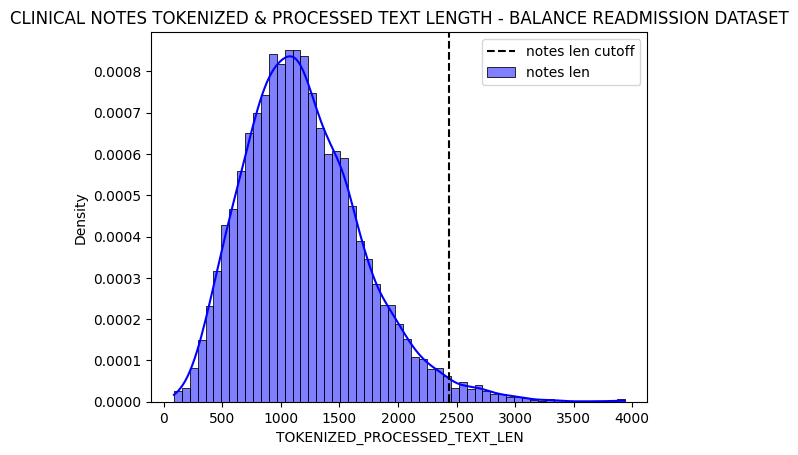

In [17]:
#rule of thumb from statistics that approximately 99.7% of data points in a normally distributed dataset lie within three standard deviations of the mean
#readmission_notes_len_cutoff = np.round(hf_readmission_notes_balanced['TEXT_LEN'].mean() + 3*hf_readmission_notes_balanced['TEXT_LEN'].std()).astype(int) 
#print(readmission_notes_len_cutoff)

#Instead of using the mean and standard deviation, consider using the median and interquartile range (IQR) to set max_seq_len,
# since the median and IQR are more robust to skewed data and outliers.

q85, q25 = np.percentile(hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'], [75 ,25])
iqr = q85 - q25
readmission_notes_len_cutoff = np.round(q85 + (1.5 * iqr)).astype(int) # Adjust 1.5 based on how inclusive you want to be of the outlier data.


print(f"Avg Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].mean()}")
print(f"Max Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].max()}")
print(f"Min Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].min()}")
print(f"Std Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].std()}")
print(f"Readmission Nots Cutoff Length: {readmission_notes_len_cutoff}")
display(hf_readmission_notes_balanced.head(5))

#https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
sns.histplot(hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'], kde=True, stat="density", color='b', label='notes len')
plt.axvline(x=readmission_notes_len_cutoff, color='k', linestyle='--', label='notes len cutoff')
plt.title('CLINICAL NOTES TOKENIZED & PROCESSED TEXT LENGTH - BALANCE READMISSION DATASET'); 
plt.legend()
plt.show()


## DOWNSAMPLE THE MAJORITY CLASS TO 30-DAY READMISSION SAMPLE 
### BALANCED SAMPLE DATASET

In [18]:

# Separate majority and minority classes
hf_30day_readmission_notes_majority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION_30DAYS == 0]
hf_30day_readmission_notes_minority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION_30DAYS == 1]
# Downsample majority class
hf_30day_readmission_notes_majority_downsampled = hf_30day_readmission_notes_majority.sample(n=len(hf_30day_readmission_notes_minority), random_state=42)
# Combine minority class with downsampled majority class
hf_30day_readmission_notes_balanced = pd.concat([hf_30day_readmission_notes_majority_downsampled, hf_30day_readmission_notes_minority])
# Shuffle the dataset to prevent the model from learning any order
hf_30day_readmission_notes_balanced = hf_30day_readmission_notes_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
# Display new class counts
print(hf_30day_readmission_notes_balanced.READMISSION_30DAYS.value_counts())

READMISSION_30DAYS
1    962
0    962
Name: count, dtype: int64


In [19]:
hf_30day_readmission_notes_balanced.head()

,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,ORIGINAL_INDEX,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,165332,32348,Admission Date: [**2145-7-13**] ...,Report,2145-07-13 00:59:00,1,1,13081,1985,admission date discharge date date birth sex s...,1372
1,170535,30348,Admission Date: [**2185-12-28**] ...,Report,2185-12-28 13:15:00,1,1,13445,1215,admission date discharge date service medicine...,859
2,111925,69265,Admission Date: [**2194-5-15**] ...,Report,2194-05-15 17:42:00,0,0,9693,2478,admission date discharge date date birth sex s...,1334
3,128989,27043,Admission Date: [**2141-10-21**] ...,Report,2141-10-21 06:35:00,0,0,9509,1682,admission date discharge date date birth sex s...,1239
4,147206,75031,Admission Date: [**2198-3-28**] ...,Report,2198-03-28 01:09:00,0,0,4716,2592,admission date discharge date date birth sex s...,1683


Avg Tokenized & Processed Notes Length: 1248.545738045738
Max Tokenized & Processed Notes Length: 4153
Min Tokenized & Processed Notes Length: 143
Std Tokenized & Processed Notes Length: 513.5316712902173
30 Day Readmission Nots Cutoff Length: 2510


,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,ORIGINAL_INDEX,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,165332,32348,Admission Date: [**2145-7-13**] ...,Report,2145-07-13 00:59:00,1,1,13081,1985,admission date discharge date date birth sex s...,1372
1,170535,30348,Admission Date: [**2185-12-28**] ...,Report,2185-12-28 13:15:00,1,1,13445,1215,admission date discharge date service medicine...,859
2,111925,69265,Admission Date: [**2194-5-15**] ...,Report,2194-05-15 17:42:00,0,0,9693,2478,admission date discharge date date birth sex s...,1334
3,128989,27043,Admission Date: [**2141-10-21**] ...,Report,2141-10-21 06:35:00,0,0,9509,1682,admission date discharge date date birth sex s...,1239
4,147206,75031,Admission Date: [**2198-3-28**] ...,Report,2198-03-28 01:09:00,0,0,4716,2592,admission date discharge date date birth sex s...,1683


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


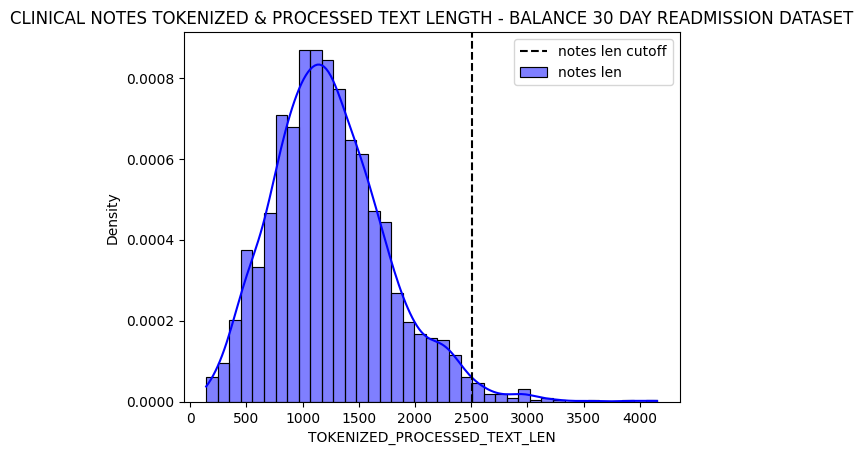

In [20]:
#rule of thumb from statistics that approximately 99.7% of data points in a normally distributed dataset lie within three standard deviations of the mean
#max_text_len_readmission = np.round(hf_readmission_notes_balanced['TEXT_LEN'].mean() + 3*hf_readmission_notes_balanced['TEXT_LEN'].std()).astype(int) 
#print(max_text_len_readmission)

#Instead of using the mean and standard deviation, consider using the median and interquartile range (IQR) to set max_seq_len,
# since the median and IQR are more robust to skewed data and outliers.

q85, q25 = np.percentile(hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'], [75 ,25])
iqr = q85 - q25
_30dayreadmission_notes_cutoff = np.round(q85 + (1.5 * iqr)).astype(int) # Adjust 1.5 based on how inclusive you want to be of the outlier data.


print(f"Avg Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].mean()}")
print(f"Max Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].max()}")
print(f"Min Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].min()}")
print(f"Std Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].std()}")
print(f"30 Day Readmission Nots Cutoff Length: {_30dayreadmission_notes_cutoff}")
display(hf_30day_readmission_notes_balanced.head(5))

#https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
sns.histplot(hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'], kde=True, stat="density", color='b', label='notes len')
plt.axvline(x=_30dayreadmission_notes_cutoff, color='k', linestyle='--', label='notes len cutoff')
plt.title('CLINICAL NOTES TOKENIZED & PROCESSED TEXT LENGTH - BALANCE 30 DAY READMISSION DATASET'); plt.legend()
plt.show()


## SPLIT DATA IN TRAIN TEST

### READMISSION BALANCED DATASET 90/10 SPLIT 

In [21]:
## READMISSION BALANCED DATASET 90/10 SPLIT 
readmission_notes_features = hf_readmission_notes_balanced[["TOKENIZED_PROCESSED_TEXT","ORIGINAL_INDEX"]]
readmission_notes_target = hf_readmission_notes_balanced["READMISSION"]
X_readmission_train, X_readmission_test, y_readmission_train, y_readmission_test = train_test_split(readmission_notes_features, readmission_notes_target, test_size=0.1, random_state=42)

print(f"readmission_notes_features Shape: {readmission_notes_features.shape}")
print(f"X_readmission_train Shape: {X_readmission_train.shape}")
print(f"X_readmission_test Shape: {X_readmission_test.shape}")
print(f"y_readmission_train Shape: {y_readmission_train.shape}")
print(f"y_readmission_test Shape: {y_readmission_test.shape}")


readmission_notes_features Shape: (7086, 2)
X_readmission_train Shape: (6377, 2)
X_readmission_test Shape: (709, 2)
y_readmission_train Shape: (6377,)
y_readmission_test Shape: (709,)


In [22]:
print(hf_readmission_notes_balanced[hf_readmission_notes_balanced["ORIGINAL_INDEX"].isin(X_readmission_train["ORIGINAL_INDEX"].tolist())].READMISSION.value_counts())
y_readmission_train.value_counts()

READMISSION
1    3199
0    3178
Name: count, dtype: int64


READMISSION
1    3199
0    3178
Name: count, dtype: int64

In [23]:
print(hf_readmission_notes_balanced[hf_readmission_notes_balanced["ORIGINAL_INDEX"].isin(X_readmission_test["ORIGINAL_INDEX"].tolist())].READMISSION.value_counts())
y_readmission_test.value_counts()

READMISSION
0    365
1    344
Name: count, dtype: int64


READMISSION
0    365
1    344
Name: count, dtype: int64

### 30-DAY READMISSION BALANCED DATASET 90/10 SPLIT 

In [24]:
## 30-DAY READMISSION BALANCED DATASET 90/10 SPLIT 
_30day_readmission_notes_features = hf_30day_readmission_notes_balanced[["TOKENIZED_PROCESSED_TEXT","ORIGINAL_INDEX"]]
_30day_readmission_notes_target = hf_30day_readmission_notes_balanced["READMISSION_30DAYS"]
X_30day_readmission_train, X_30day_readmission_test, y_30day_readmission_train, y_30day_readmission_test = train_test_split(_30day_readmission_notes_features, _30day_readmission_notes_target, test_size=0.1, random_state=42)

print(f"readmission_notes_features Shape: {_30day_readmission_notes_features.shape}")
print(f"X_readmission_train Shape: {X_30day_readmission_train.shape}")
print(f"X_readmission_test Shape: {X_30day_readmission_test.shape}")
print(f"y_readmission_train Shape: {y_30day_readmission_train.shape}")
print(f"y_readmission_test Shape: {y_30day_readmission_test.shape}")

readmission_notes_features Shape: (1924, 2)
X_readmission_train Shape: (1731, 2)
X_readmission_test Shape: (193, 2)
y_readmission_train Shape: (1731,)
y_readmission_test Shape: (193,)


In [25]:
#hf_30day_readmission_notes_balanced[hf_30day_readmission_notes_balanced["ORIGINAL_INDEX"].isin(X_30day_readmission_train["ORIGINAL_INDEX"].tolist())]
print(hf_30day_readmission_notes_balanced[hf_30day_readmission_notes_balanced["ORIGINAL_INDEX"].isin(X_30day_readmission_train["ORIGINAL_INDEX"].tolist())].READMISSION_30DAYS.value_counts())
y_30day_readmission_train.value_counts()

READMISSION_30DAYS
1    867
0    864
Name: count, dtype: int64


READMISSION_30DAYS
1    867
0    864
Name: count, dtype: int64

In [26]:
collate_fn = utility.create_collate_fn(pubmed_pmc_wordvector, readmission_notes_len_cutoff)
# Creating the DataLoader with the custom collate function
readmission_train_dataset_noembed = TextDataset(X_readmission_train[0:50], y_readmission_train[0:50])
readmission_test_dataset_noembed = TextDataset(X_readmission_test[0:2], y_readmission_test[0:2])        

dataloader = torch.utils.data.DataLoader(readmission_train_dataset_noembed, batch_size=32, collate_fn=collate_fn)
for i, (embeddings, labels,original_batch_indices) in enumerate(dataloader):
    print(f"Batch {i}")
    print(f"Embeddings shape: {embeddings.shape}")
    print(f'original_batch_indices: {len(original_batch_indices)} - {original_batch_indices}')
    print(f"Labels: {len(labels)}")
    #display(hf_admission_notes_with_labels[hf_admission_notes_with_labels["ORIGINAL_INDEX"].isin(original_batch_indices)][["TOKENIZED_PROCESSED_TEXT","ORIGINAL_INDEX"]] )
    print(hf_admission_notes_with_labels[hf_admission_notes_with_labels["ORIGINAL_INDEX"].isin(original_batch_indices)].READMISSION.value_counts())
    #print(hf_admission_notes_with_labels[hf_admission_notes_with_labels["ORIGINAL_INDEX"].isin(original_batch_indices)].READMISSION.value_counts())

    if i == 10:  # Change this number to see more or fewer batches
        break

Batch 0
Embeddings shape: torch.Size([32, 1, 2435, 200])
original_batch_indices: 32 - (7880, 11717, 2396, 10069, 12578, 7936, 12168, 3395, 7156, 12293, 5339, 10989, 2529, 9494, 11374, 5718, 10333, 5534, 11763, 13737, 10573, 10343, 12186, 10235, 10585, 9180, 13146, 5406, 10523, 11183, 1751, 11408)
Labels: 32
READMISSION
1    18
0    14
Name: count, dtype: int64
Batch 1
Embeddings shape: torch.Size([18, 1, 2435, 200])
original_batch_indices: 18 - (4776, 7640, 12565, 11137, 3077, 11106, 13695, 13399, 2481, 6344, 12806, 10809, 11509, 8, 6273, 10939, 1357, 11228)
Labels: 18
READMISSION
1    10
0     8
Name: count, dtype: int64


In [27]:
readmission_notes_len_cutoff

2435

In [34]:
n_filters = [300]*3
filter_sizes = [3,4,5]
for i,j in zip(filter_sizes, n_filters):
    print(i,j)

3 300
4 300
5 300


In [43]:
import math

BATCH_SIZE = 32
USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.



#from ReadmissionCNN import *
PATH_OUTPUT = "./output_fullDS/readmission/"

# Hyperparameters
#N_FILTERS = [500,400,300,500,400,300,500,400,300]  # number of filters
N_FILTERS = [200]*8 # number of filters
FILTER_SIZES = [2,3,4,5]*2  # list of filter sizes
OUTPUT_DIM = 2  # number of output classes, adjust according to your task
DROPOUT = 0.3  # dropout rate
EMBEDDING_DIM = 200  # embedding dimension
learning_rate = 0.0001
l2_lambda = 1e-5

# Create an instance of the CNN class
cnn_readmission_model_collatefn = ReadmissionCNN(N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, EMBEDDING_DIM)
#cnn_readmission_model_collatefn = ReadmissionCNN_Enhanced_Local(N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, EMBEDDING_DIM)
#cnn_readmission_model_collatefn = VariedFilterReadmissionCNN_Local(EMBEDDING_DIM, OUTPUT_DIM)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_readmission_model_collatefn = cnn_readmission_model_collatefn.to(device)

# Define loss function and optimizer
criterion_collatefn = nn.CrossEntropyLoss().to(device)
#optimizer_collatefn = torch.optim.Adam(cnn_readmission_model_collatefn.parameters())
optimizer_collatefn = torch.optim.Adam(cnn_readmission_model_collatefn.parameters(), lr=learning_rate, weight_decay=l2_lambda)

## CLOSURE
#Closure is a function object that remembers values in enclosing scopes even if they are not present in memory. 
#It's a way to keep track of variables from an outer function that are used in an inner function
collate_fn = utility.create_collate_fn(pubmed_pmc_wordvector, readmission_notes_len_cutoff)

NUM_EPOCHS = 10
best_val_acc_collatefn = 0.0
train_losses_collatefn, train_accuracies_collatefn = [], []
valid_losses_collatefn, valid_accuracies_collatefn = [], []

for epoch in range(NUM_EPOCHS):

	X_readmission_train_epoch, X_readmission_test_epoch, y_readmission_train_epoch, y_readmission_test_epoch = train_test_split(X_readmission_train, y_readmission_train, test_size=0.1, random_state=epoch)

	# Create an instance of your custom dataset
	readmission_train_dataset_noembed = TextDataset(X_readmission_train_epoch, y_readmission_train_epoch)
	readmission_test_dataset_noembed = TextDataset(X_readmission_test_epoch, y_readmission_test_epoch)        

	train_loader_readmission_embed = torch.utils.data.DataLoader(readmission_train_dataset_noembed, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
	test_loader_readmission_embed = torch.utils.data.DataLoader(readmission_test_dataset_noembed, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)


	train_loss_collatefn, train_accuracy_collatefn = utility.train(cnn_readmission_model_collatefn, device, train_loader_readmission_embed, criterion_collatefn, optimizer_collatefn, epoch)
	valid_loss_collatefn, valid_accuracy_collatefn, valid_results_collatefn,correct_pos_indices,correct_neg_indices = utility.evaluate(cnn_readmission_model_collatefn, device, test_loader_readmission_embed, criterion_collatefn)

	train_losses_collatefn.append(train_loss_collatefn)
	valid_losses_collatefn.append(valid_loss_collatefn)

	train_accuracies_collatefn.append(train_accuracy_collatefn)
	valid_accuracies_collatefn.append(valid_accuracy_collatefn)

	is_best_collatefn = valid_accuracy_collatefn > best_val_acc_collatefn  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best_collatefn:
		print(f"Best Validation Accuracy: {valid_accuracy_collatefn}")
		best_val_acc_collatefn = valid_accuracy_collatefn
		torch.save(cnn_readmission_model_collatefn, os.path.join(PATH_OUTPUT, "cnn_readmission_final_model_collatefn_fullDS.pth"), _use_new_zipfile_serialization=False)
		#torch.save(cnn_readmission_model_collatefn, os.path.join(PATH_OUTPUT, "cnn_readmission_model_enhanced_collatefn_fullDS.pth"), _use_new_zipfile_serialization=False)
		#torch.save(cnn_readmission_model_collatefn, os.path.join(PATH_OUTPUT, "cnn_readmission_model_varied_collatefn_fullDS.pth"), _use_new_zipfile_serialization=False)

Epoch: [0][0/180]	Time 0.728 (0.728)	Data 0.172 (0.172)	Loss 0.6893 (0.6893)	Accuracy 59.375 (59.375)
Epoch: [0][10/180]	Time 0.342 (0.394)	Data 0.225 (0.232)	Loss 0.6876 (0.6942)	Accuracy 59.375 (48.295)
Epoch: [0][20/180]	Time 0.352 (0.377)	Data 0.235 (0.232)	Loss 0.7000 (0.6936)	Accuracy 40.625 (48.363)
Epoch: [0][30/180]	Time 0.356 (0.370)	Data 0.228 (0.233)	Loss 0.6919 (0.6946)	Accuracy 56.250 (48.185)
Epoch: [0][40/180]	Time 0.370 (0.367)	Data 0.246 (0.233)	Loss 0.6737 (0.6944)	Accuracy 68.750 (49.314)
Epoch: [0][50/180]	Time 0.345 (0.365)	Data 0.227 (0.233)	Loss 0.6805 (0.6937)	Accuracy 65.625 (50.797)
Epoch: [0][60/180]	Time 0.364 (0.364)	Data 0.238 (0.234)	Loss 0.6942 (0.6934)	Accuracy 46.875 (50.717)
Epoch: [0][70/180]	Time 0.370 (0.364)	Data 0.250 (0.234)	Loss 0.6959 (0.6940)	Accuracy 53.125 (50.528)
Epoch: [0][80/180]	Time 0.348 (0.363)	Data 0.224 (0.234)	Loss 0.7088 (0.6949)	Accuracy 50.000 (50.193)
Epoch: [0][90/180]	Time 0.378 (0.363)	Data 0.256 (0.235)	Loss 0.6809 (0.69

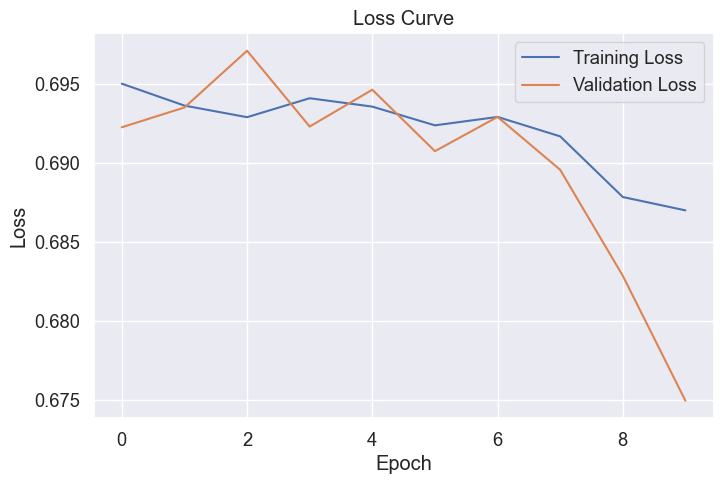

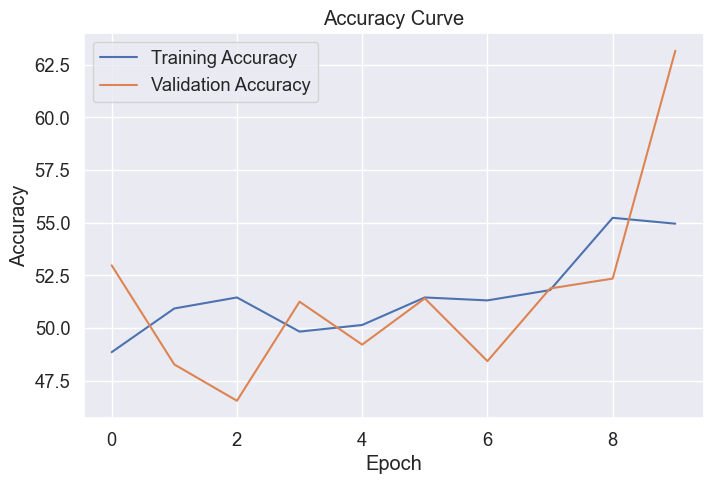

Test: [0/23]	Time 0.202 (0.202)	Loss 0.6754 (0.6754)	Accuracy 59.375 (59.375)
Test: [5/23]	Time 0.350 (0.322)	Loss 0.6774 (0.6772)	Accuracy 56.250 (61.458)
Test: [10/23]	Time 0.357 (0.333)	Loss 0.6675 (0.6747)	Accuracy 68.750 (63.636)
Test: [15/23]	Time 0.342 (0.335)	Loss 0.6779 (0.6789)	Accuracy 56.250 (59.961)
Test: [20/23]	Time 0.353 (0.338)	Loss 0.6893 (0.6801)	Accuracy 53.125 (59.821)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


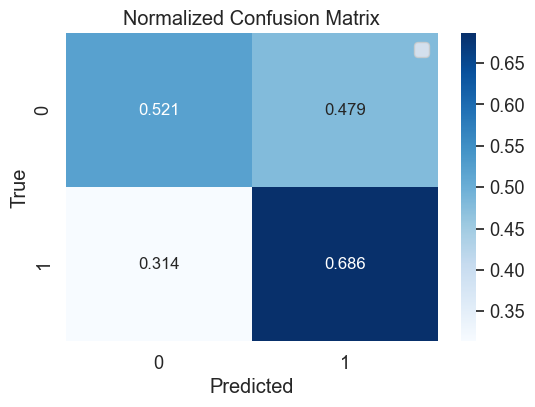

Maximum train accuracy: 55.23610385150979
Maximum test accuracy: 63.166144320209945
              precision    recall  f1-score   support

           0       0.64      0.52      0.57       365
           1       0.57      0.69      0.63       344

    accuracy                           0.60       709
   macro avg       0.61      0.60      0.60       709
weighted avg       0.61      0.60      0.60       709

Accuracy: 0.6008462623413258
F1 Score: 0.6251655629139071


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, f1_score

utility.plot_learning_curves(train_losses_collatefn, valid_losses_collatefn, train_accuracies_collatefn, valid_accuracies_collatefn)


best_cnn_readmission_model = torch.load(os.path.join(PATH_OUTPUT, "cnn_readmission_final_model_collatefn_fullDS.pth"))
#best_cnn_readmission_model = torch.load(os.path.join(PATH_OUTPUT, "cnn_readmission_model_enhanced_collatefn_fullDS.pth"))
#best_cnn_readmission_model = torch.load(os.path.join(PATH_OUTPUT, "cnn_readmission_model_varied_collatefn_fullDS.pth"))

readmission_test_dataset_noembed = TextDataset(X_readmission_test, y_readmission_test)        
test_loader_readmission_embed = torch.utils.data.DataLoader(readmission_test_dataset_noembed, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

valid_loss_collatefn, valid_accuracy_collatefn, valid_results_collatefn,valid_correct_pos_indices_readmission,valid_correct_neg_indices_readmission = utility.evaluate(best_cnn_readmission_model, device, test_loader_readmission_embed, criterion_collatefn)

class_names = [0,1]
utility.plot_confusion_matrix(valid_results_collatefn, class_names)

y_true_collatefn, y_pred_collatefn = zip(*valid_results_collatefn)
#print(np.unique(y_true))
#print(np.unique(y_pred))

print(f"Maximum train accuracy: {np.max(train_accuracies_collatefn)}")
print(f"Maximum test accuracy: {np.max(valid_accuracies_collatefn)}")
#print(len(valid_results))
#print(np.where([(yt==yp) for yt,yp in valid_results])[0].shape[0]/len(valid_results))
print(classification_report(y_true_collatefn, y_pred_collatefn))
print("Accuracy:", accuracy_score(y_true_collatefn, y_pred_collatefn))
print("F1 Score:", f1_score(y_true_collatefn, y_pred_collatefn, average='binary'))

In [ ]:
print(len(valid_correct_pos_indices_readmission))
print(len(valid_correct_neg_indices_readmission))

## CHI-SQUARE ANALYSIS

### GENERAL READMISSION CHI-SQAURE ANALYSIS

In [208]:
from collections import Counter

orig_pos_pred_pos_notes_readmission = hf_admission_notes_with_labels.loc[valid_correct_pos_indices_readmission][["TOKENIZED_PROCESSED_TEXT","READMISSION","ORIGINAL_INDEX","TOKENIZED_PROCESSED_TEXT_LEN"]]
orig_neg_pred_neg_notes_readmission = hf_admission_notes_with_labels.loc[valid_correct_neg_indices_readmission][["TOKENIZED_PROCESSED_TEXT","READMISSION","ORIGINAL_INDEX","TOKENIZED_PROCESSED_TEXT_LEN"]]

# Function to extract words from notes
def extract_words(notes):
    all_words = []
    for note in notes:
        words = note.split()  # Assuming words are space-separated
        all_words.extend(words)
    return all_words

# Calculate frequencies
positive_word_freq_readmission = Counter(extract_words(orig_pos_pred_pos_notes_readmission['TOKENIZED_PROCESSED_TEXT']))
negative_word_freq_readmission = Counter(extract_words(orig_neg_pred_neg_notes_readmission['TOKENIZED_PROCESSED_TEXT']))

total_positive_words_readmission = sum(positive_word_freq_readmission.values())
total_negative_words_readmission = sum(negative_word_freq_readmission.values())
total_words_readmission = total_positive_words_readmission + total_negative_words_readmission
print(f'total_positive_words: {total_positive_words_readmission} - total_negative_words: {total_negative_words_readmission} - total_words: {total_words_readmission}')



# Initialize a dictionary to store chi-square results
chi_square_readmission_results = {}

# Get all unique words from both positive and negative frequencies
all_words_readmission = set(positive_word_freq_readmission.keys()).union(set(negative_word_freq_readmission.keys()))

for word in all_words_readmission:
    # Observed frequencies
    obs_positive_readmission = positive_word_freq_readmission[word]
    obs_negative_readmission = negative_word_freq_readmission[word]

    #Total Occurrences of the Word:
    #Total occurrences of word=Observed frequency in positive+Observed frequency in negative
    total_occurrences_readmission = obs_positive_readmission + obs_negative_readmission

    #Proportion of Words in Each Class:
    # Proportion of positive words =  Total positive words/Total words
    # Proportion of negative words =  Total negative words/Total words
    prop_postive_readmission = (total_positive_words_readmission / total_words_readmission)
    prop_negative_readmission = (total_negative_words_readmission / total_words_readmission)


    # Expected frequencies
    exp_positive_readmission = total_occurrences_readmission * prop_postive_readmission
    exp_negative_readmission = total_occurrences_readmission * prop_negative_readmission

    # Chi-square calculation
    chi_square_readmission = ((obs_positive_readmission - exp_positive_readmission) ** 2 / exp_positive_readmission) + ((obs_negative_readmission - exp_negative_readmission) ** 2 / exp_negative_readmission)
    chi_square_readmission_results[word] = chi_square_readmission

# Optionally, convert the results to a DataFrame for easier analysis
chi_square_readmission_df = pd.DataFrame.from_dict(chi_square_readmission_results, orient='index', columns=['chi_square']).reset_index().rename(columns={'index': 'Feature'})
positive_word_freq_readmission_df = pd.DataFrame.from_dict(positive_word_freq_readmission, orient='index', columns=['positive_class_freq']).reset_index().rename(columns={'index': 'Feature'})
negative_word_freq_readmission_df = pd.DataFrame.from_dict(negative_word_freq_readmission, orient='index', columns=['negative_class_freq']).reset_index().rename(columns={'index': 'Feature'})

chi_square_readmission_df = chi_square_readmission_df.merge(positive_word_freq_readmission_df[['Feature', 'positive_class_freq']], on='Feature', how='left')
chi_square_readmission_df = chi_square_readmission_df.merge(negative_word_freq_readmission_df[['Feature', 'negative_class_freq']], on='Feature', how='left')

chi_square_readmission_df["feature_positive_leaning"] = chi_square_readmission_df["positive_class_freq"] > chi_square_readmission_df["negative_class_freq"]

chi_square_readmission_df.sort_values(by='chi_square', ascending=False).head(20)

total_positive_words: 312741 - total_negative_words: 191159 - total_words: 503900


,Feature,chi_square,positive_class_freq,negative_class_freq,feature_positive_leaning
12623,aortic,290.476352,400.0,683.0,False
10407,valve,244.577096,429.0,667.0,False
7073,postoperative,205.748866,31.0,183.0,False
13916,aorta,167.298509,85.0,232.0,False
8920,incisions,131.878678,6.0,93.0,False
3801,left,121.851096,1500.0,1380.0,True
9987,descending,120.891485,31.0,127.0,False
9730,bypass,119.207398,54.0,157.0,False
2405,mitral,117.842610,327.0,434.0,False
11849,pod,115.289789,14.0,97.0,False


In [210]:
#top20_GR_correct_pred_features_df
chi_square_readmission_df.sort_values(by='chi_square', ascending=False)[:20]

,Feature,chi_square,positive_class_freq,negative_class_freq,feature_positive_leaning
12623,aortic,290.476352,400.0,683.0,False
10407,valve,244.577096,429.0,667.0,False
7073,postoperative,205.748866,31.0,183.0,False
13916,aorta,167.298509,85.0,232.0,False
8920,incisions,131.878678,6.0,93.0,False
3801,left,121.851096,1500.0,1380.0,True
9987,descending,120.891485,31.0,127.0,False
9730,bypass,119.207398,54.0,157.0,False
2405,mitral,117.842610,327.0,434.0,False
11849,pod,115.289789,14.0,97.0,False


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtyp

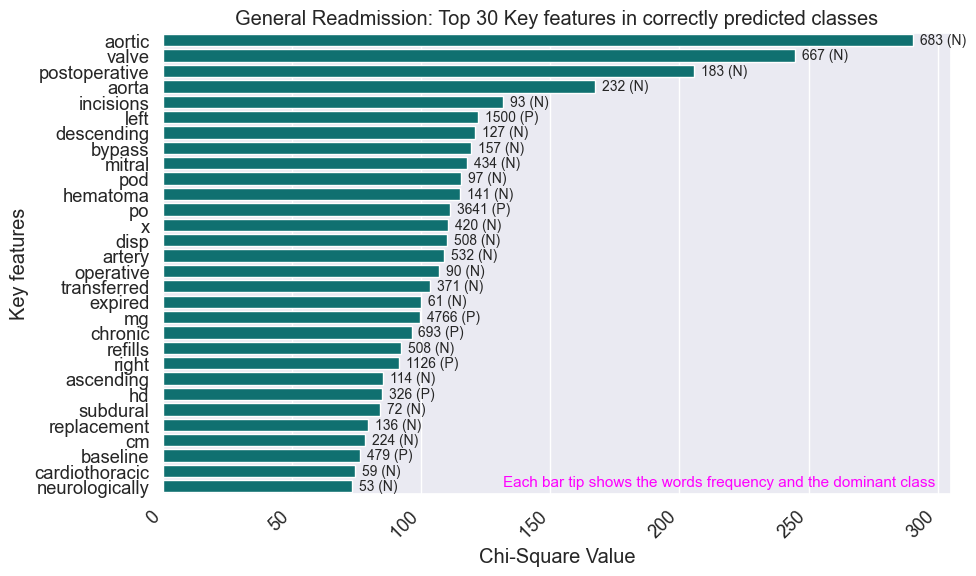

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(10, 6))

top20_GR_correct_pred_features_df = chi_square_readmission_df.sort_values(by='chi_square', ascending=False)[:30]
# Create a bar plot for Chi-square values
bar_plot = sns.barplot(x='chi_square', y='Feature', data=top20_GR_correct_pred_features_df, color='teal')


# Annotate each bar with the value of the class frequency
for bar in bar_plot.patches:
    row = top20_GR_correct_pred_features_df[top20_GR_correct_pred_features_df["chi_square"]==bar.get_width()].iloc[0]
    #print(row)
    frequency = format(row["positive_class_freq"],'.0f')+ " (P)"
    if row["feature_positive_leaning"] == False:
        frequency = format(row["negative_class_freq"],'.0f')+" (N)"

    bar_plot.annotate(frequency, 
                      (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                      ha='left', va='center',
                      size=10, xytext=(5, 0),
                      textcoords='offset points')

# Add a note on the plot to indicate that the annotations are class frequencies
plt.text(0.98, 0.01, 'Each bar tip shows the words frequency and the dominant class', 
         verticalalignment='bottom', horizontalalignment='right',
         transform=plt.gca().transAxes, color='magenta', fontsize=11)

# Create a line plot for Class Frequency on the same plot
#sns.lineplot(x='Feature', y='positive_class_freq', data=chi_square_readmission_positive_df[:20], marker='o', color='red', label='Class Frequency')

# Improve the aesthetics
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.ylabel('Key features')
plt.xlabel('Chi-Square Value')
plt.title('General Readmission: Top 30 Key features in correctly predicted classes')
#plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [156]:
chi_square_readmission_df["feature_positive_leaning"] = chi_square_readmission_df["positive_class_freq"] > chi_square_readmission_df["negative_class_freq"]
chi_square_readmission_positive_df = chi_square_readmission_df[chi_square_readmission_df["feature_positive_leaning"]==True].sort_values(by='chi_square', ascending=False)[["Feature","chi_square","positive_class_freq"]]
chi_square_readmission_positive_df.head(20)

,Feature,chi_square,positive_class_freq
5613,hd,204.305952,272.0
1614,dialysis,135.999705,182.0
6384,torsemide,99.864722,78.0
13309,esrd,98.351624,107.0
13482,insulin,98.162502,351.0
10011,diastolic,81.043786,209.0
10524,nph,77.399006,82.0
1728,chf,72.668654,361.0
9800,ward,63.103513,159.0
10490,bipap,62.991299,99.0


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtyp

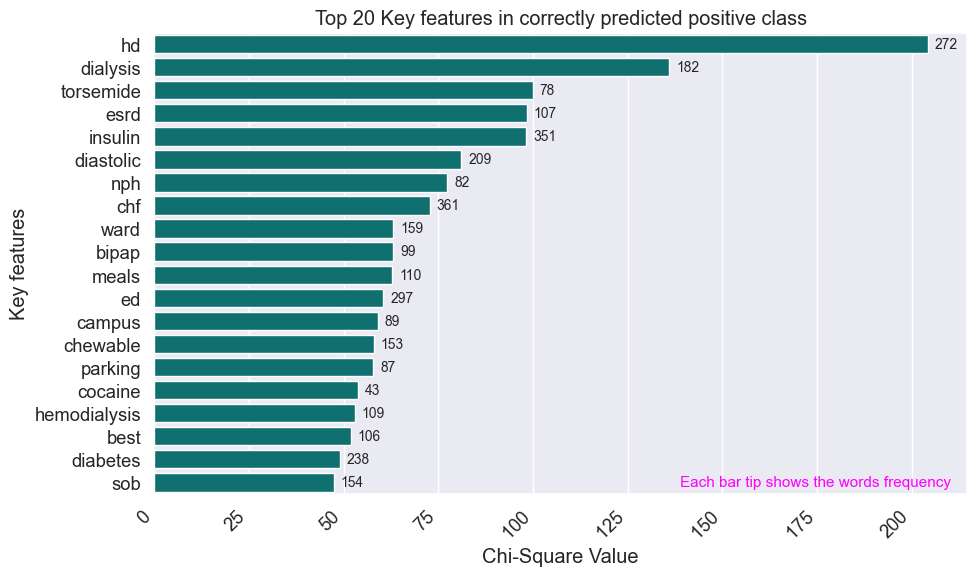

In [198]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a bar plot for Chi-square values
bar_plot = sns.barplot(x='chi_square', y='Feature', data=chi_square_readmission_positive_df[:20], color='teal')


# Annotate each bar with the value of the class frequency
for bar, frequency in zip(bar_plot.patches, chi_square_readmission_positive_df['positive_class_freq']):
    bar_plot.annotate(format(frequency, '.0f'), 
                      (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                      ha='left', va='center',
                      size=10, xytext=(5, 0),
                      textcoords='offset points')

# Add a note on the plot to indicate that the annotations are class frequencies
plt.text(0.98, 0.01, 'Each bar tip shows the word''s frequency', 
         verticalalignment='bottom', horizontalalignment='right',
         transform=plt.gca().transAxes, color='magenta', fontsize=11)

# Create a line plot for Class Frequency on the same plot
#sns.lineplot(x='Feature', y='positive_class_freq', data=chi_square_readmission_positive_df[:20], marker='o', color='red', label='Class Frequency')

# Improve the aesthetics
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.ylabel('Key features')
plt.xlabel('Chi-Square Value')
plt.title('Top 20 Key features in correctly predicted positive class')
#plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [163]:
chi_square_readmission_negative_df = chi_square_readmission_df[chi_square_readmission_df["feature_positive_leaning"]==False].sort_values(by='chi_square', ascending=False)[["Feature","chi_square","negative_class_freq"]]

chi_square_readmission_negative_df.head(20)

,Feature,chi_square,negative_class_freq
1149,po,199.231008,2873.0
4403,tablet,147.552172,3960.0
12829,aortic,143.300121,968.0
10623,valve,123.201040,918.0
13061,sig,113.160451,2381.0
9113,mg,107.219059,4094.0
11283,home,87.454291,654.0
7218,postoperative,86.479576,201.0
7645,osh,81.782019,243.0
3875,left,80.640284,2175.0


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtyp

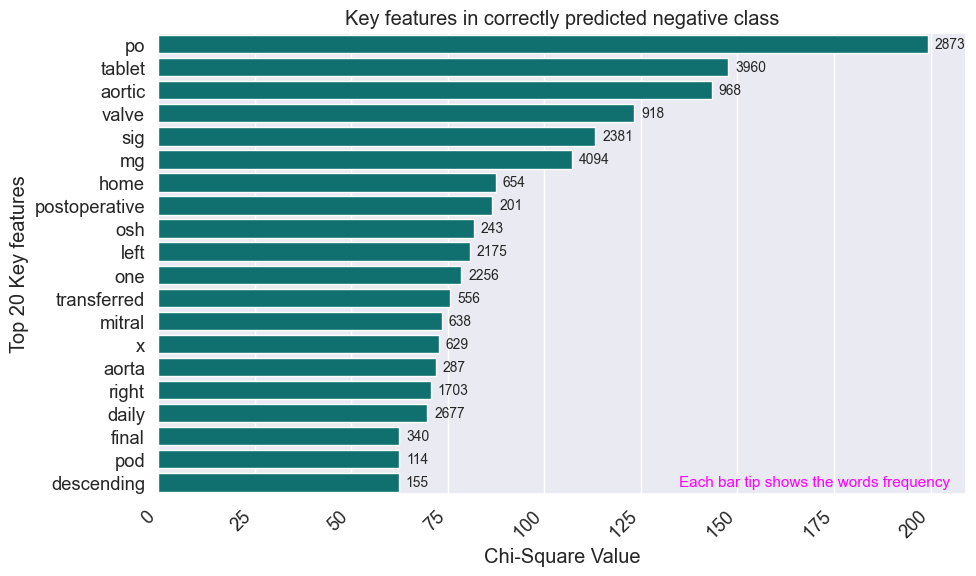

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a bar plot for Chi-square values
bar_plot = sns.barplot(x='chi_square', y='Feature', data=chi_square_readmission_negative_df[:20], color='teal')

# Annotate each bar with the value of the class frequency
for bar, frequency in zip(bar_plot.patches, chi_square_readmission_negative_df['negative_class_freq']):
    bar_plot.annotate(format(frequency, '.0f'), 
                      (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                      ha='left', va='center',
                      size=10, xytext=(5, 0),
                      textcoords='offset points')

# Add a note on the plot to indicate that the annotations are class frequencies
plt.text(0.98, 0.01, 'Each bar tip shows the word''s frequency', 
         verticalalignment='bottom', horizontalalignment='right',
         transform=plt.gca().transAxes, color='magenta', fontsize=11)

# Create a line plot for Class Frequency on the same plot
#sns.lineplot(x='Feature', y='negative_class_freq', data=chi_square_readmission_negative_df[:20], marker='o', color='red', label='Class Frequency')

# Improve the aesthetics
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.ylabel('Top 20 Key features')
plt.xlabel('Chi-Square Value')
plt.title('Key features in correctly predicted negative class')
#plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [144]:



print(len(all_words_readmission))



15426


In [ ]:
display(chi_square_readmission_df.sort_values(by='chi_square', ascending=False).head(20))

In [ ]:
from utility import *
from ReadmissionCNN import *

In [69]:
_30dayreadmission_notes_cutoff = 2510
#_30dayreadmission_notes_cutoff = 4000
#_30dayreadmission_notes_cutoff = 3500

In [92]:
import ReadmissionCNN

In [96]:
importlib.reload(ReadmissionCNN)

<module 'ReadmissionCNN' from 'c:\\Users\\ssiddiqui\\OneDrive\\Education\\GT-OMSA\\CSE-6250-Big-Data-Health\\Project\\BD4H_FINAL\\ReadmissionCNN.py'>

In [135]:

import math

BATCH_SIZE = 32
USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

#_30day_X_readmission_train_epoch, _30day_X_readmission_test_epoch, _30day_y_readmission_train_epoch, _30day_y_readmission_test_epoch = train_test_split(X_30day_readmission_train, y_30day_readmission_train, test_size=0.1, random_state=epoch)

# Create an instance of your custom dataset
_30day_readmission_train_dataset_noembed = TextDataset(X_30day_readmission_train, y_30day_readmission_train)
_30day_readmission_test_dataset_noembed = TextDataset(X_30day_readmission_test, y_30day_readmission_test)        

train_loader_30day_readmission_embed = torch.utils.data.DataLoader(_30day_readmission_train_dataset_noembed, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader_30day_readmission_embed = torch.utils.data.DataLoader(_30day_readmission_test_dataset_noembed, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

#from ReadmissionCNN import *
PATH_OUTPUT = "./output_fullDS/readmission/"

# Hyperparameters
#N_FILTERS = [500,400,300,500,400,300,500,400,300]  # number of filters
N_FILTERS = [200]*4 # number of filters
FILTER_SIZES = [1,2,3,4]  # list of filter sizes
OUTPUT_DIM = 2  # number of output classes, adjust according to your task
DROPOUT = 0.1 # dropout rate
EMBEDDING_DIM = 200  # embedding dimension
learning_rate = 0.001
l2_lambda = 1e-4

# Create an instance of the CNN class
cnn_30day_readmission_model_collatefn = ReadmissionCNN.ReadmissionCNN(N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, EMBEDDING_DIM)
#cnn_30day_readmission_model_collatefn = ReadmissionCNN_Enhanced_Local(N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, EMBEDDING_DIM)
#cnn_30day_readmission_model_collatefn = VariedFilterReadmissionCNN_Local(EMBEDDING_DIM, OUTPUT_DIM)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_30day_readmission_model_collatefn = cnn_30day_readmission_model_collatefn.to(device)

# Define loss function and optimizer
criterion_collatefn_30day = nn.CrossEntropyLoss().to(device)
#optimizer_collatefn = torch.optim.Adam(cnn_30day_readmission_model_collatefn.parameters())
optimizer_collatefn_30day = torch.optim.Adam(cnn_30day_readmission_model_collatefn.parameters(), lr=learning_rate, weight_decay=l2_lambda)

collate_fn = utility.create_collate_fn(pubmed_pmc_wordvector, _30dayreadmission_notes_cutoff)

NUM_EPOCHS = 15
best_val_acc_collatefn_30day = 0.0
train_losses_collatefn_30day, train_accuracies_collatefn_30day = [], []
valid_losses_collatefn_30day, valid_accuracies_collatefn_30day = [], []

for epoch in range(NUM_EPOCHS):

	train_loss_collatefn_30day, train_accuracy_collatefn_30day = utility.train(cnn_30day_readmission_model_collatefn, device, train_loader_30day_readmission_embed, criterion_collatefn_30day, optimizer_collatefn_30day, epoch)
	valid_loss_collatefn_30day, valid_accuracy_collatefn_30day, valid_results_collatefn_30day,correct_pos_indices_30day,correct_neg_indices_30day = utility.evaluate(cnn_30day_readmission_model_collatefn, device, test_loader_30day_readmission_embed, criterion_collatefn_30day)

	train_losses_collatefn_30day.append(train_loss_collatefn_30day)
	valid_losses_collatefn_30day.append(valid_loss_collatefn_30day)

	train_accuracies_collatefn_30day.append(train_accuracy_collatefn_30day)
	valid_accuracies_collatefn_30day.append(valid_accuracy_collatefn_30day)

	is_best_collatefn_30day = valid_accuracy_collatefn_30day > best_val_acc_collatefn_30day  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best_collatefn_30day:
		print(f"Best Validation Accuracy: {valid_accuracy_collatefn_30day}")
		best_val_acc_collatefn_30day = valid_accuracy_collatefn_30day
		torch.save(cnn_30day_readmission_model_collatefn, os.path.join(PATH_OUTPUT, "cnn_30day_readmission_final_model_collatefn_fullDS.pth"), _use_new_zipfile_serialization=False)
		#torch.save(cnn_30day_readmission_model_collatefn, os.path.join(PATH_OUTPUT, "cnn_30day_readmission_model_enhanced_collatefn_fullDS.pth"), _use_new_zipfile_serialization=False)
		#torch.save(cnn_30day_readmission_model_collatefn, os.path.join(PATH_OUTPUT, "cnn_30day_readmission_model_varied_collatefn_fullDS.pth"), _use_new_zipfile_serialization=False)

Epoch: [0][0/55]	Time 0.536 (0.536)	Data 0.157 (0.157)	Loss 0.7206 (0.7206)	Accuracy 40.625 (40.625)
Epoch: [0][10/55]	Time 0.292 (0.327)	Data 0.217 (0.219)	Loss 0.6971 (0.7021)	Accuracy 40.625 (44.602)
Epoch: [0][20/55]	Time 0.299 (0.315)	Data 0.214 (0.220)	Loss 0.6937 (0.6989)	Accuracy 46.875 (46.131)
Epoch: [0][30/55]	Time 0.323 (0.315)	Data 0.244 (0.224)	Loss 0.6967 (0.6974)	Accuracy 46.875 (47.278)
Epoch: [0][40/55]	Time 0.299 (0.312)	Data 0.222 (0.225)	Loss 0.6963 (0.6967)	Accuracy 50.000 (47.332)
Epoch: [0][50/55]	Time 0.309 (0.312)	Data 0.231 (0.226)	Loss 0.6941 (0.6968)	Accuracy 59.375 (47.304)
Test: [0/7]	Time 0.239 (0.239)	Loss 0.6874 (0.6874)	Accuracy 59.375 (59.375)
Test: [5/7]	Time 0.304 (0.288)	Loss 0.6974 (0.6939)	Accuracy 43.750 (48.958)
Best Validation Accuracy: 49.22279792746114
Epoch: [1][0/55]	Time 0.301 (0.301)	Data 0.203 (0.203)	Loss 0.6831 (0.6831)	Accuracy 59.375 (59.375)
Epoch: [1][10/55]	Time 0.307 (0.308)	Data 0.232 (0.221)	Loss 0.6805 (0.6915)	Accuracy 62.5

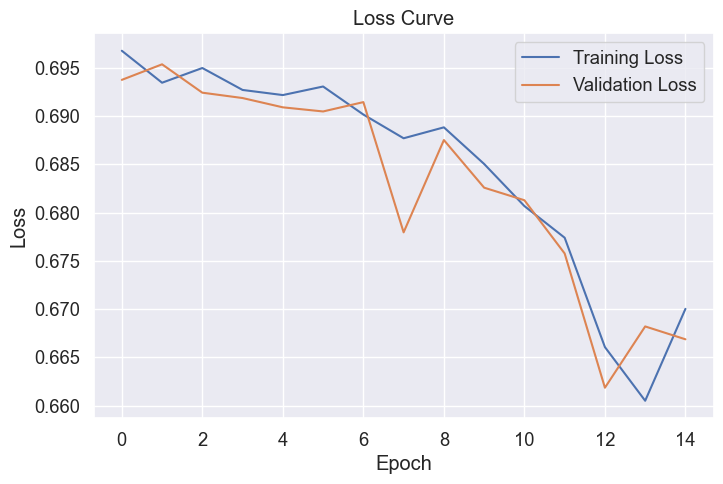

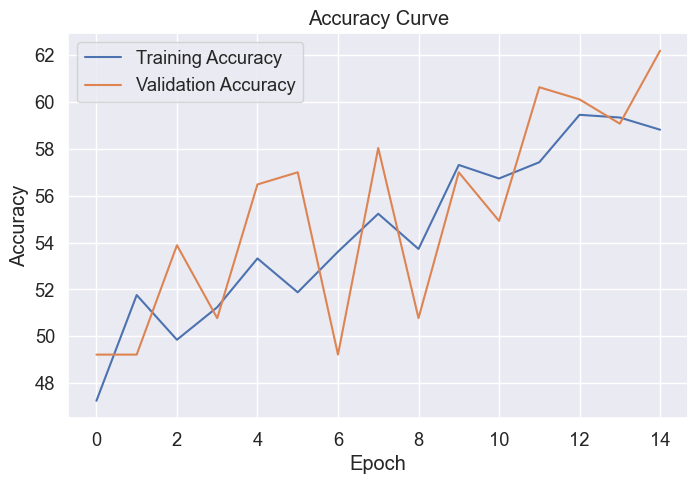

Test: [0/7]	Time 0.228 (0.228)	Loss 0.6598 (0.6598)	Accuracy 62.500 (62.500)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test: [5/7]	Time 0.284 (0.320)	Loss 0.6779 (0.6668)	Accuracy 65.625 (61.979)


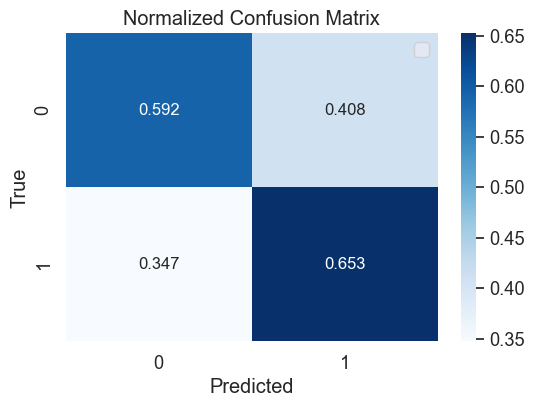

Maximum train accuracy: 59.44540727902946
Maximum test accuracy: 62.17616580310881
              precision    recall  f1-score   support

           0       0.64      0.59      0.61        98
           1       0.61      0.65      0.63        95

    accuracy                           0.62       193
   macro avg       0.62      0.62      0.62       193
weighted avg       0.62      0.62      0.62       193

Accuracy: 0.6217616580310881
F1 Score: 0.6294416243654823


In [136]:

utility.plot_learning_curves(train_losses_collatefn_30day, valid_losses_collatefn_30day, train_accuracies_collatefn_30day, valid_accuracies_collatefn_30day)


best_cnn_30day_readmission_model = torch.load(os.path.join(PATH_OUTPUT, "cnn_30day_readmission_final_model_collatefn_fullDS.pth"))

#_30day_readmission_test_dataset_noembed = TextDataset(X_30day_readmission_test, y_30day_readmission_test)        
#test_loader_30day_readmission_embed = torch.utils.data.DataLoader(_30day_readmission_test_dataset_noembed, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

valid_loss_collatefn_30day, valid_accuracy_collatefn_30day, valid_results_collatefn_30day, valid_correct_pos_indices_readmission_30day,valid_correct_neg_indices_readmission_30day = utility.evaluate(best_cnn_30day_readmission_model, device, test_loader_30day_readmission_embed, criterion_collatefn_30day)



class_names = [0,1]
utility.plot_confusion_matrix(valid_results_collatefn_30day, class_names)

y_true_collatefn_30day, y_pred_collatefn_30day = zip(*valid_results_collatefn_30day)
#print(np.unique(y_true))
#print(np.unique(y_pred))

print(f"Maximum train accuracy: {np.max(train_accuracies_collatefn_30day)}")
print(f"Maximum test accuracy: {np.max(valid_accuracies_collatefn_30day)}")
#print(len(valid_results))
#print(np.where([(yt==yp) for yt,yp in valid_results])[0].shape[0]/len(valid_results))
print(classification_report(y_true_collatefn_30day, y_pred_collatefn_30day))
print("Accuracy:", accuracy_score(y_true_collatefn_30day, y_pred_collatefn_30day))
print("F1 Score:", f1_score(y_true_collatefn_30day, y_pred_collatefn_30day, average='binary'))

## CHI-SQUARE ANALYSIS

### GENERAL READMISSION CHI-SQAURE ANALYSIS

In [231]:
from collections import Counter

orig_pos_pred_pos_notes_readmission_30day = hf_admission_notes_with_labels.loc[valid_correct_pos_indices_readmission_30day][["TOKENIZED_PROCESSED_TEXT","READMISSION","ORIGINAL_INDEX","TOKENIZED_PROCESSED_TEXT_LEN"]]
orig_neg_pred_neg_notes_readmission_30day = hf_admission_notes_with_labels.loc[valid_correct_neg_indices_readmission_30day][["TOKENIZED_PROCESSED_TEXT","READMISSION","ORIGINAL_INDEX","TOKENIZED_PROCESSED_TEXT_LEN"]]

# Function to extract words from notes
def extract_words(notes):
    all_words = []
    for note in notes:
        words = note.split()  # Assuming words are space-separated
        all_words.extend(words)
    return all_words

# Calculate frequencies
positive_word_freq_readmission_30day = Counter(extract_words(orig_pos_pred_pos_notes_readmission_30day['TOKENIZED_PROCESSED_TEXT']))
negative_word_freq_readmission_30day = Counter(extract_words(orig_neg_pred_neg_notes_readmission_30day['TOKENIZED_PROCESSED_TEXT']))

total_positive_words_readmission_30day = sum(positive_word_freq_readmission_30day.values())
total_negative_words_readmission_30day = sum(negative_word_freq_readmission_30day.values())
total_words_readmission_30day = total_positive_words_readmission_30day + total_negative_words_readmission_30day
print(f'total_positive_words: {total_positive_words_readmission_30day} - total_negative_words: {total_negative_words_readmission_30day} - total_words: {total_words_readmission_30day}')



# Initialize a dictionary to store chi-square results
chi_square_readmission_30day_results = {}

# Get all unique words from both positive and negative frequencies
all_words_readmission_30day = set(positive_word_freq_readmission_30day.keys()).union(set(negative_word_freq_readmission_30day.keys()))

for word in all_words_readmission_30day:
    # Observed frequencies
    obs_positive_readmission_30day = positive_word_freq_readmission_30day[word]
    obs_negative_readmission_30day = negative_word_freq_readmission_30day[word]

    #Total Occurrences of the Word:
    #Total occurrences of word = Observed frequency in positive + Observed frequency in negative
    total_occurrences_readmission_30day = obs_positive_readmission_30day + obs_negative_readmission_30day

    #Proportion of Words in Each Class:
    # Proportion of positive words =  Total positive words/Total words
    # Proportion of negative words =  Total negative words/Total words
    prop_postive_readmission_30day = (total_positive_words_readmission_30day / total_words_readmission_30day)
    prop_negative_readmission_30day = (total_negative_words_readmission_30day / total_words_readmission_30day)


    # Expected frequencies
    exp_positive_readmission_30day = total_occurrences_readmission_30day * prop_postive_readmission_30day
    exp_negative_readmission_30day = total_occurrences_readmission_30day * prop_negative_readmission_30day

    # Chi-square calculation
    chi_square_readmission_30day = ((obs_positive_readmission_30day - exp_positive_readmission_30day) ** 2 / exp_positive_readmission_30day) + ((obs_negative_readmission_30day - exp_negative_readmission_30day) ** 2 / exp_negative_readmission_30day)
    chi_square_readmission_30day_results[word] = chi_square_readmission_30day

#convert the results to a DataFrame for easier analysis
chi_square_readmission_30day_df = pd.DataFrame.from_dict(chi_square_readmission_30day_results, orient='index', columns=['chi_square']).reset_index().rename(columns={'index': 'Feature'})
positive_word_freq_readmission_30day_df = pd.DataFrame.from_dict(positive_word_freq_readmission_30day, orient='index', columns=['positive_class_freq']).reset_index().rename(columns={'index': 'Feature'})
negative_word_freq_readmission_30day_df = pd.DataFrame.from_dict(negative_word_freq_readmission_30day, orient='index', columns=['negative_class_freq']).reset_index().rename(columns={'index': 'Feature'})

chi_square_readmission_30day_df = chi_square_readmission_30day_df.merge(positive_word_freq_readmission_30day_df[['Feature', 'positive_class_freq']], on='Feature', how='left')
chi_square_readmission_30day_df = chi_square_readmission_30day_df.merge(negative_word_freq_readmission_30day_df[['Feature', 'negative_class_freq']], on='Feature', how='left')

chi_square_readmission_30day_df["feature_positive_leaning"] = chi_square_readmission_30day_df["positive_class_freq"] > chi_square_readmission_30day_df["negative_class_freq"]

chi_square_readmission_30day_df.sort_values(by='chi_square', ascending=False).head(20)

total_positive_words: 88408 - total_negative_words: 56588 - total_words: 144996


,Feature,chi_square,positive_class_freq,negative_class_freq,feature_positive_leaning
5900,patient,171.869153,649.0,817.0,False
115,q,129.837820,23.0,126.0,False
8350,postoperative,75.983440,2.0,53.0,False
585,number,73.129518,30.0,96.0,False
528,job,65.091840,2.0,46.0,False
3817,coronary,61.638783,64.0,128.0,False
7309,p,59.960037,251.0,307.0,False
3005,mouth,52.648310,38.0,90.0,False
566,laboratory,48.117521,1.0,33.0,False
6961,white,47.253061,13.0,53.0,False


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtyp

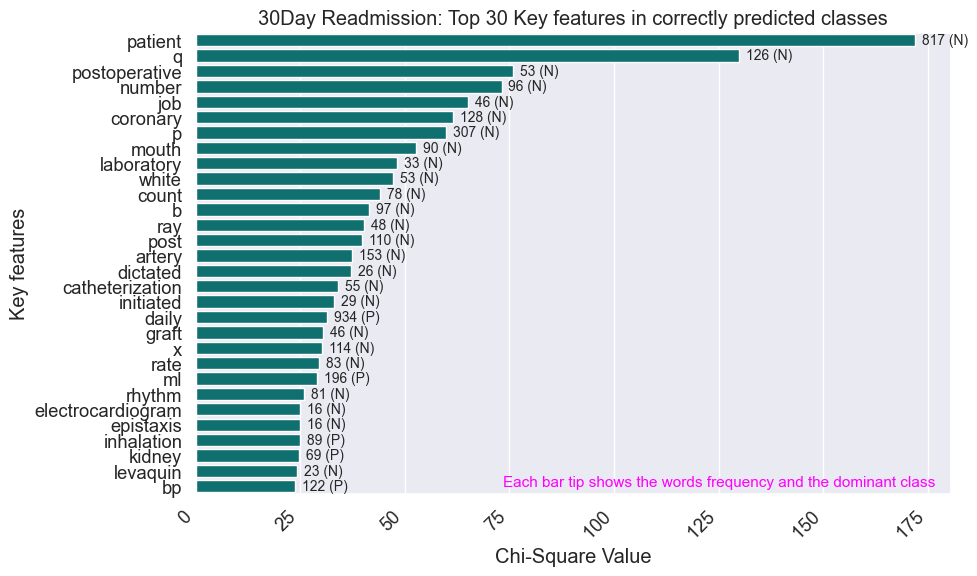

In [234]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(10, 6))

top20_30R_correct_pred_features_df = chi_square_readmission_30day_df.sort_values(by='chi_square', ascending=False)[:30]
# Create a bar plot for Chi-square values
bar_plot = sns.barplot(x='chi_square', y='Feature', data=top20_30R_correct_pred_features_df, color='teal')


# Annotate each bar with the value of the class frequency
for bar in bar_plot.patches:
    row = top20_30R_correct_pred_features_df[top20_30R_correct_pred_features_df["chi_square"]==bar.get_width()].iloc[0]
    #print(row)
    frequency = format(row["positive_class_freq"],'.0f')+ " (P)"
    if row["feature_positive_leaning"] == False:
        frequency = format(row["negative_class_freq"],'.0f')+" (N)"

    bar_plot.annotate(frequency, 
                      (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                      ha='left', va='center',
                      size=10, xytext=(5, 0),
                      textcoords='offset points')

# Add a note on the plot to indicate that the annotations are class frequencies
plt.text(0.98, 0.01, 'Each bar tip shows the words frequency and the dominant class', 
         verticalalignment='bottom', horizontalalignment='right',
         transform=plt.gca().transAxes, color='magenta', fontsize=11)

# Create a line plot for Class Frequency on the same plot
#sns.lineplot(x='Feature', y='positive_class_freq', data=chi_square_readmission_positive_df[:20], marker='o', color='red', label='Class Frequency')

# Improve the aesthetics
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.ylabel('Key features')
plt.xlabel('Chi-Square Value')
plt.title('30Day Readmission: Top 30 Key features in correctly predicted classes')
#plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [176]:
chi_square_readmission_30day_df["feature_positive_leaning"] = chi_square_readmission_30day_df["positive_class_freq"] > chi_square_readmission_30day_df["negative_class_freq"]
chi_square_readmission_30day_df[chi_square_readmission_30day_df["feature_positive_leaning"]==True].sort_values(by='chi_square', ascending=False)[["Feature","chi_square","positive_class_freq"]].head(20)
chi_square_readmission_30day_positive_df = chi_square_readmission_30day_df[chi_square_readmission_30day_df["feature_positive_leaning"]==True].sort_values(by='chi_square', ascending=False)[["Feature","chi_square","positive_class_freq"]]
chi_square_readmission_30day_positive_df.head(20)

,Feature,chi_square,positive_class_freq
1683,daily,31.452617,934.0
5369,ml,28.937450,196.0
457,inhalation,24.971503,89.0
4634,kidney,24.768687,69.0
6855,bp,23.769719,122.0
860,day,22.719420,635.0
8385,cocaine,22.428017,39.0
7055,ed,21.569792,145.0
8335,gi,21.132738,87.0
6253,sig,20.234277,866.0


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtyp

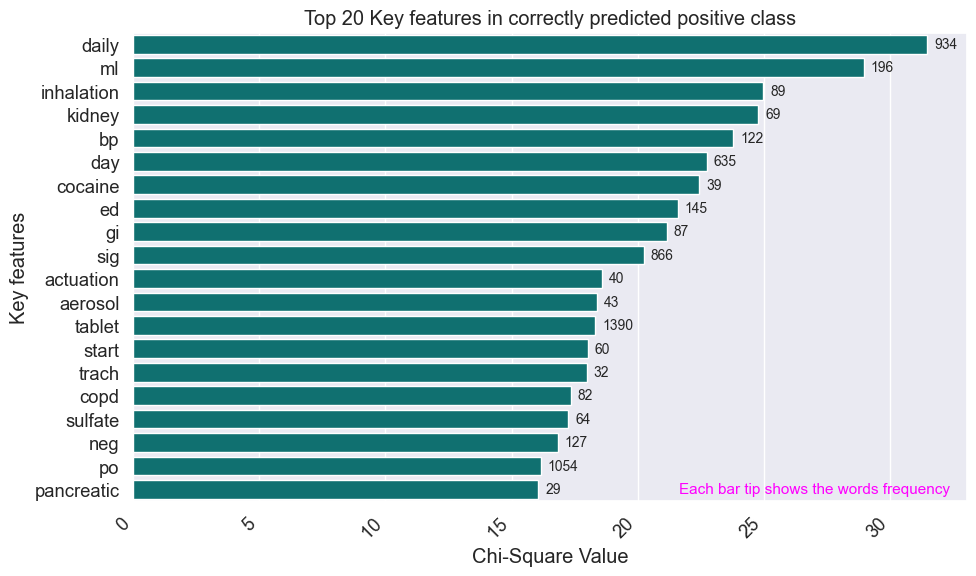

In [200]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a bar plot for Chi-square values
bar_plot = sns.barplot(x='chi_square', y='Feature', data=chi_square_readmission_30day_positive_df[:20], color='teal')

# Annotate each bar with the value of the class frequency
for bar, frequency in zip(bar_plot.patches, chi_square_readmission_30day_positive_df['positive_class_freq']):
    bar_plot.annotate(format(frequency, '.0f'), 
                      (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                      ha='left', va='center',
                      size=10, xytext=(5, 0),
                      textcoords='offset points')

# Add a note on the plot to indicate that the annotations are class frequencies
plt.text(0.98, 0.01, 'Each bar tip shows the word''s frequency', 
         verticalalignment='bottom', horizontalalignment='right',
         transform=plt.gca().transAxes, color='magenta', fontsize=11)

# Create a line plot for Class Frequency on the same plot
#sns.lineplot(x='Feature', y='negative_class_freq', data=chi_square_readmission_positive_df[:20], marker='o', color='red', label='Class Frequency')

# Improve the aesthetics
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.ylabel('Key features')
plt.xlabel('Chi-Square Value')
plt.title('Top 20 Key features in correctly predicted positive class')
#plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [179]:
chi_square_readmission_30day_negative_df = chi_square_readmission_30day_df[chi_square_readmission_30day_df["feature_positive_leaning"]==False].sort_values(by='chi_square', ascending=False)[["Feature","chi_square","negative_class_freq"]]
chi_square_readmission_30day_negative_df.head(20)

,Feature,chi_square,negative_class_freq
5900,patient,171.869153,817.0
115,q,129.837820,126.0
8350,postoperative,75.983440,53.0
585,number,73.129518,96.0
528,job,65.091840,46.0
3817,coronary,61.638783,128.0
7309,p,59.960037,307.0
3005,mouth,52.648310,90.0
566,laboratory,48.117521,33.0
6961,white,47.253061,53.0


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtyp

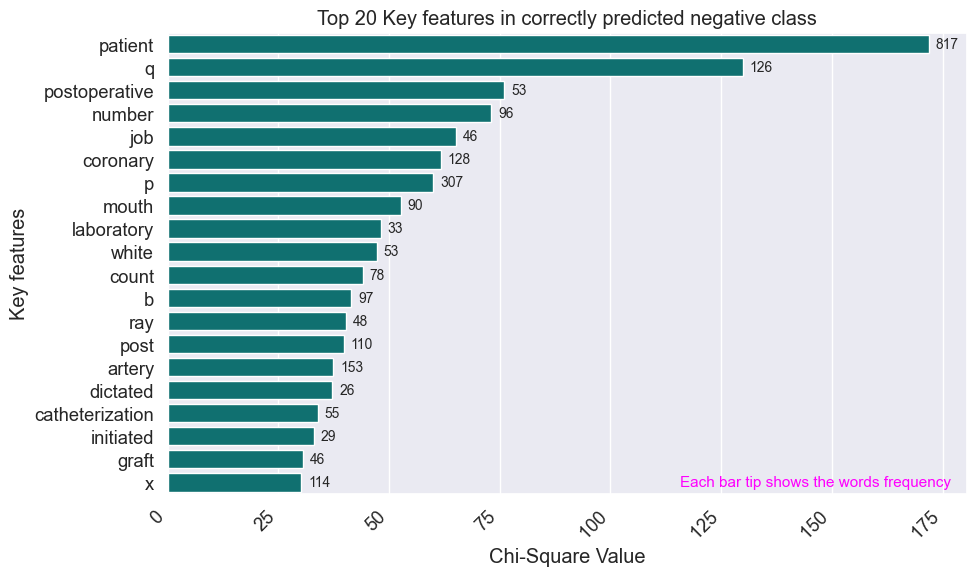

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a bar plot for Chi-square values
bar_plot = sns.barplot(x='chi_square', y='Feature', data=chi_square_readmission_30day_negative_df[:20], color='teal')

# Annotate each bar with the value of the class frequency
for bar, frequency in zip(bar_plot.patches, chi_square_readmission_30day_negative_df['negative_class_freq']):
    bar_plot.annotate(format(frequency, '.0f'), 
                      (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                      ha='left', va='center',
                      size=10, xytext=(5, 0),
                      textcoords='offset points')

# Add a note on the plot to indicate that the annotations are class frequencies
plt.text(0.98, 0.01, 'Each bar tip shows the word''s frequency', 
         verticalalignment='bottom', horizontalalignment='right',
         transform=plt.gca().transAxes, color='magenta', fontsize=11)

# Create a line plot for Class Frequency on the same plot
#sns.lineplot(x='Feature', y='negative_class_freq', data=chi_square_readmission_positive_df[:20], marker='o', color='red', label='Class Frequency')

# Improve the aesthetics
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.ylabel('Key features')
plt.xlabel('Chi-Square Value')
plt.title('Top 20 Key features in correctly predicted negative class')
#plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Random Forest

### Balanced Data Random Forest General Readmission

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns


# Initialize lists to collect metrics
# its decision trees so they typically get like 100% acccuracy/F1 on training, not interesting to view 


v = TfidfVectorizer()
X_train, X_test, y_train, y_test = train_test_split(hf_readmission_notes_balanced['TEXT'], 
                                                    hf_readmission_notes_balanced['READMISSION'], 
                                                    test_size=0.1, 
                                                    random_state=6250, 
                                                    stratify=hf_readmission_notes_balanced['READMISSION'])

# Fit the vectorizer on the training data
tfidf_scores_train = v.fit_transform(X_train)

# Only transform the test data using the already fitted vectorizer
tfidf_scores_test = v.transform(X_test)

f1s = [] 
accuracies = []
# estimators = [1, 10, 25, 50, 100, 125, 150]
estimators = [1, 50, 100, 150, 200, 300]
max_feats = [10000, 15000, 20000, 25000]


for feats in max_feats:
    for estimator in estimators:
        random_forest_model = RandomForestClassifier(n_estimators=estimator, bootstrap=True, class_weight="balanced",
                                                     max_features=feats, random_state=6250)
        # Use the TF-IDF transformed training data
        random_forest_model.fit(tfidf_scores_train, y_train)
        # Use the TF-IDF transformed test data to make predictions
        y_pred = random_forest_model.predict(tfidf_scores_test)

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        f1s.append(f1)
        accuracies.append(accuracy)    
        print(f"Estimators: {estimator} | Features: {feats} | Precision: {precision:.4f} | Recall: {recall:.4f} | Accuracy: {accuracy:.4f} | F1: {f1:.4f}")


#
# Plotting  
# rename var to preserve data in memory for experimentation and to not re-run above cell on mistakes... 

print(len(hf_readmission_notes_balanced))

f1_copy = f1s
print(f1_copy)
#f1_copy.reverse()
f1_scores_array = np.array(f1_copy)
f1_scores_reshaped = f1_scores_array.reshape(len(max_feats), len(estimators))
print(f1_scores_reshaped)
df = pd.DataFrame(f1_scores_reshaped, index=max_feats, columns=estimators)

# Generate the heatmap
plt.clf()
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt=".2f", cbar_kws={'label': 'F1 Score'})
plt.title('F1 Scores Heatmap')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Features')
plt.show()
plt.clf()


### Balanced Data Random Forest 30day Readmission

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

v = TfidfVectorizer()
X_train, X_test, y_train, y_test = train_test_split(
    hf_30day_readmission_notes_balanced['TEXT'], 
    hf_30day_readmission_notes_balanced['READMISSION'], 
    test_size=0.1, 
    random_state=6250,
    stratify=hf_30day_readmission_notes_balanced['READMISSION']
)


# Fit the vectorizer on the training data
tfidf_scores_train = v.fit_transform(X_train)

# Only transform the test data using the already fitted vectorizer
tfidf_scores_test = v.transform(X_test)

f1s = [] 
accuracies = []
# estimators = [1, 10, 25, 50, 100, 125, 150]
estimators = [1, 50, 100, 150, 200, 300]
max_feats = [10000, 15000, 20000, 25000]


for feats in max_feats:
    for estimator in estimators:
        random_forest_model = RandomForestClassifier(n_estimators=estimator, bootstrap=True, class_weight="balanced",
                                                     max_features=feats, random_state=6250)
        # Use the TF-IDF transformed training data
        random_forest_model.fit(tfidf_scores_train, y_train)
        # Use the TF-IDF transformed test data to make predictions
        y_pred = random_forest_model.predict(tfidf_scores_test)

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        f1s.append(f1)
        accuracies.append(accuracy)    
        print(f"Estimators: {estimator} | Features: {feats} | Precision: {precision:.4f} | Recall: {recall:.4f} | Accuracy: {accuracy:.4f} | F1: {f1:.4f}")



# Plotting  
# rename var to preserve data in memory for experimentation and to not re-run above cell on mistakes... 

print(len(hf_readmission_notes_balanced))

f1_copy = f1s
print(f1_copy)
#f1_copy.reverse()
f1_scores_array = np.array(f1_copy)
f1_scores_reshaped = f1_scores_array.reshape(len(max_feats), len(estimators))
print(f1_scores_reshaped)
df = pd.DataFrame(f1_scores_reshaped, index=max_feats, columns=estimators)

# Generate the heatmap
plt.clf()
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt=".2f", cbar_kws={'label': 'F1 Score'})
plt.title('F1 Scores Heatmap')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Features')
plt.show()
plt.clf()